<a href="https://colab.research.google.com/github/KingPegasus/DeepLearning/blob/master/GAN/dcgan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional GAN (DCGAN) with MNIST

This is a follow-up on [gan_mnist.ipynb](gan_mnist.ipynb).  It uses deep convolutional networks in the generator and the discriminator.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


We only use the images not the categorical labels.

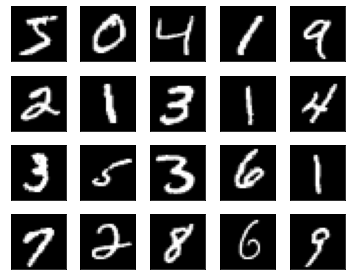

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The original DCGAN paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

In this notebook, I used smaller networks than what the original paper [[3]](#ref3) uses as our image size is 28x28 and it has only 1 channel.

The generator takes a latent sample of 100 random numbers and generates a 28x28 image with 1 channel.

The first layer accepts 784 data points just like [gan_mnist.ipynb](gan_mnist.ipynb).  Then, it reshapes the data into 7x7 with 16 filters.  Afterwards, two transposed convolution layers will up-sample the data shape into 28x28.

For the details of the tranposed convolution, see [transposed_convolution.ipynb](transposed_convolution.ipynb).

In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 28x28 image with 1 channel.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [gan_mnist.ipynb](gan_mnist.ipynb), I used a fully connected layer with 784 (=28x28) neurons.  To make this discriminator comparable, I use the same number of neurons in the last fully connected hidden layer, and then added convolution layers beforehands.

Note: using the decreasing number of filters may be a bit unusual but I did this to make the discriminator network and the generator network to have same kind of increase in the number of convolutional network neurons (hopefully keeping their power in balance).

In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

### About Batch Normalization

As for the batch normalization, it was applied to most of the layers but not all.  The below is a quote from the original DCGAN paper [[3]](#ref3).

> Directly applying batchnorm to all layers, however, resulted in sample oscillation and model instability. This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer.


## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The below is to show the losses.

In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()    

The below is to show the generated images.

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [14]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 2.4086 Generator Loss: 1.1678
Epoch:  2/100 Discriminator Loss: 2.1304 Generator Loss: 1.1766
Epoch:  3/100 Discriminator Loss: 8.6046 Generator Loss: 6.6261
Epoch:  4/100 Discriminator Loss: 7.7730 Generator Loss: 6.8762
Epoch:  5/100 Discriminator Loss: 2.8783 Generator Loss: 3.3592
Epoch:  6/100 Discriminator Loss: 1.7162 Generator Loss: 2.0113
Epoch:  7/100 Discriminator Loss: 3.6945 Generator Loss: 3.9396
Epoch:  8/100 Discriminator Loss: 3.5098 Generator Loss: 2.4038
Epoch:  9/100 Discriminator Loss: 3.6551 Generator Loss: 3.4136
Epoch: 10/100 Discriminator Loss: 3.4597 Generator Loss: 3.1408


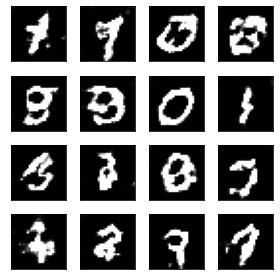

Epoch: 11/100 Discriminator Loss: 1.3225 Generator Loss: 0.7950
Epoch: 12/100 Discriminator Loss: 8.1582 Generator Loss: 8.1662
Epoch: 13/100 Discriminator Loss: 3.4349 Generator Loss: 4.1413
Epoch: 14/100 Discriminator Loss: 2.3434 Generator Loss: 1.8773
Epoch: 15/100 Discriminator Loss: 3.2773 Generator Loss: 2.5772
Epoch: 16/100 Discriminator Loss: 5.6656 Generator Loss: 6.3075
Epoch: 17/100 Discriminator Loss: 2.4118 Generator Loss: 0.5644
Epoch: 18/100 Discriminator Loss: 2.8349 Generator Loss: 3.1963
Epoch: 19/100 Discriminator Loss: 5.4083 Generator Loss: 4.6696
Epoch: 20/100 Discriminator Loss: 5.6797 Generator Loss: 5.2637


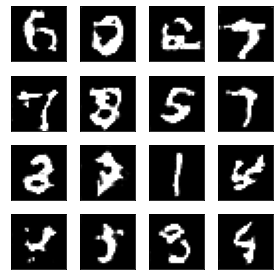

Epoch: 21/100 Discriminator Loss: 2.7338 Generator Loss: 3.2369
Epoch: 22/100 Discriminator Loss: 1.8405 Generator Loss: 2.3693
Epoch: 23/100 Discriminator Loss: 2.7046 Generator Loss: 2.1862
Epoch: 24/100 Discriminator Loss: 7.1206 Generator Loss: 7.0455
Epoch: 25/100 Discriminator Loss: 3.0472 Generator Loss: 0.7168
Epoch: 26/100 Discriminator Loss: 7.6581 Generator Loss: 6.9635
Epoch: 27/100 Discriminator Loss: 2.7615 Generator Loss: 3.7482
Epoch: 28/100 Discriminator Loss: 6.6374 Generator Loss: 6.4542
Epoch: 29/100 Discriminator Loss: 3.0081 Generator Loss: 2.9198
Epoch: 30/100 Discriminator Loss: 2.8425 Generator Loss: 3.0166


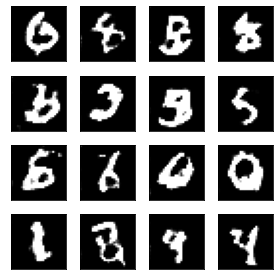

Epoch: 31/100 Discriminator Loss: 2.8434 Generator Loss: 4.6431
Epoch: 32/100 Discriminator Loss: 4.9788 Generator Loss: 6.3076
Epoch: 33/100 Discriminator Loss: 7.1941 Generator Loss: 6.9719
Epoch: 34/100 Discriminator Loss: 1.2639 Generator Loss: 1.4630
Epoch: 35/100 Discriminator Loss: 1.8844 Generator Loss: 2.2001
Epoch: 36/100 Discriminator Loss: 4.9933 Generator Loss: 3.9720
Epoch: 37/100 Discriminator Loss: 7.3952 Generator Loss: 7.2914
Epoch: 38/100 Discriminator Loss: 4.1368 Generator Loss: 5.1316
Epoch: 39/100 Discriminator Loss: 3.8639 Generator Loss: 3.3876
Epoch: 40/100 Discriminator Loss: 1.5494 Generator Loss: 0.6022


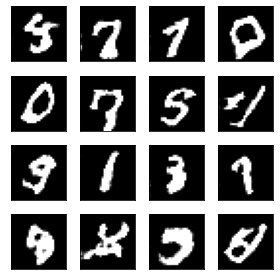

Epoch: 41/100 Discriminator Loss: 1.2527 Generator Loss: 1.5018
Epoch: 42/100 Discriminator Loss: 1.3737 Generator Loss: 1.2481
Epoch: 43/100 Discriminator Loss: 1.6767 Generator Loss: 1.6284
Epoch: 44/100 Discriminator Loss: 2.1894 Generator Loss: 3.1929
Epoch: 45/100 Discriminator Loss: 2.1571 Generator Loss: 1.6006
Epoch: 46/100 Discriminator Loss: 2.0332 Generator Loss: 2.5782
Epoch: 47/100 Discriminator Loss: 2.1121 Generator Loss: 2.1234
Epoch: 48/100 Discriminator Loss: 1.4922 Generator Loss: 1.3247
Epoch: 49/100 Discriminator Loss: 3.1277 Generator Loss: 3.7095
Epoch: 50/100 Discriminator Loss: 1.3292 Generator Loss: 1.1973


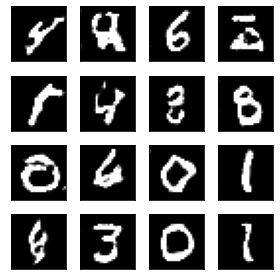

Epoch: 51/100 Discriminator Loss: 1.3298 Generator Loss: 1.2510
Epoch: 52/100 Discriminator Loss: 1.6302 Generator Loss: 2.0236
Epoch: 53/100 Discriminator Loss: 2.0264 Generator Loss: 2.6855
Epoch: 54/100 Discriminator Loss: 5.1545 Generator Loss: 5.3714
Epoch: 55/100 Discriminator Loss: 2.5009 Generator Loss: 2.2944
Epoch: 56/100 Discriminator Loss: 2.0473 Generator Loss: 2.3332
Epoch: 57/100 Discriminator Loss: 2.7920 Generator Loss: 2.4693
Epoch: 58/100 Discriminator Loss: 2.2623 Generator Loss: 1.6762
Epoch: 59/100 Discriminator Loss: 1.8663 Generator Loss: 2.1386
Epoch: 60/100 Discriminator Loss: 1.9956 Generator Loss: 2.9678


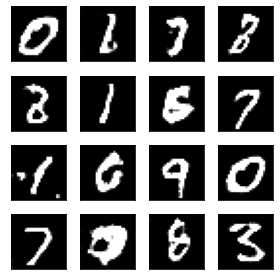

Epoch: 61/100 Discriminator Loss: 1.7392 Generator Loss: 2.2472
Epoch: 62/100 Discriminator Loss: 1.6999 Generator Loss: 1.1899
Epoch: 63/100 Discriminator Loss: 1.5206 Generator Loss: 1.1671
Epoch: 64/100 Discriminator Loss: 3.5155 Generator Loss: 3.3794
Epoch: 65/100 Discriminator Loss: 1.9595 Generator Loss: 2.3318
Epoch: 66/100 Discriminator Loss: 3.6048 Generator Loss: 3.6676
Epoch: 67/100 Discriminator Loss: 1.7905 Generator Loss: 1.6327
Epoch: 68/100 Discriminator Loss: 1.9343 Generator Loss: 2.2442
Epoch: 69/100 Discriminator Loss: 2.3107 Generator Loss: 3.1072
Epoch: 70/100 Discriminator Loss: 1.2616 Generator Loss: 1.8988


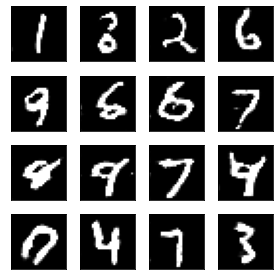

Epoch: 71/100 Discriminator Loss: 1.4591 Generator Loss: 1.2866
Epoch: 72/100 Discriminator Loss: 1.5428 Generator Loss: 1.7323
Epoch: 73/100 Discriminator Loss: 1.1326 Generator Loss: 0.8855
Epoch: 74/100 Discriminator Loss: 2.8186 Generator Loss: 3.4424
Epoch: 75/100 Discriminator Loss: 1.8325 Generator Loss: 2.1920
Epoch: 76/100 Discriminator Loss: 4.2551 Generator Loss: 3.6510
Epoch: 77/100 Discriminator Loss: 2.1413 Generator Loss: 2.3692
Epoch: 78/100 Discriminator Loss: 2.5717 Generator Loss: 3.5816
Epoch: 79/100 Discriminator Loss: 3.0176 Generator Loss: 3.7342
Epoch: 80/100 Discriminator Loss: 2.2142 Generator Loss: 3.7726


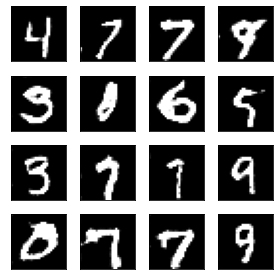

Epoch: 81/100 Discriminator Loss: 4.0643 Generator Loss: 5.0588
Epoch: 82/100 Discriminator Loss: 5.4607 Generator Loss: 4.5160
Epoch: 83/100 Discriminator Loss: 1.6620 Generator Loss: 1.9459
Epoch: 84/100 Discriminator Loss: 4.2094 Generator Loss: 4.3973
Epoch: 85/100 Discriminator Loss: 5.3450 Generator Loss: 5.6710
Epoch: 86/100 Discriminator Loss: 1.6586 Generator Loss: 3.1826
Epoch: 87/100 Discriminator Loss: 2.6161 Generator Loss: 2.4141
Epoch: 88/100 Discriminator Loss: 2.8059 Generator Loss: 2.9955
Epoch: 89/100 Discriminator Loss: 3.2384 Generator Loss: 3.2990
Epoch: 90/100 Discriminator Loss: 3.6511 Generator Loss: 4.2984


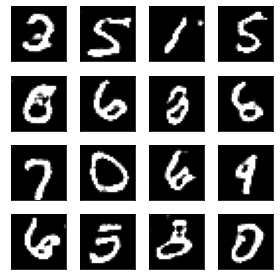

Epoch: 91/100 Discriminator Loss: 2.1245 Generator Loss: 3.2425
Epoch: 92/100 Discriminator Loss: 1.3042 Generator Loss: 1.3749
Epoch: 93/100 Discriminator Loss: 1.7048 Generator Loss: 2.0420
Epoch: 94/100 Discriminator Loss: 1.8513 Generator Loss: 3.0916
Epoch: 95/100 Discriminator Loss: 2.1338 Generator Loss: 3.6240
Epoch: 96/100 Discriminator Loss: 1.0599 Generator Loss: 1.6769
Epoch: 97/100 Discriminator Loss: 2.7762 Generator Loss: 3.6727
Epoch: 98/100 Discriminator Loss: 2.1644 Generator Loss: 2.1790
Epoch: 99/100 Discriminator Loss: 6.4912 Generator Loss: 4.8275
Epoch:100/100 Discriminator Loss: 4.1150 Generator Loss: 5.1377


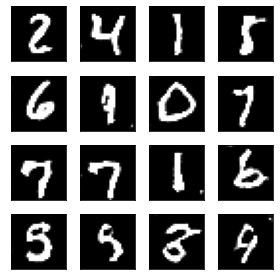

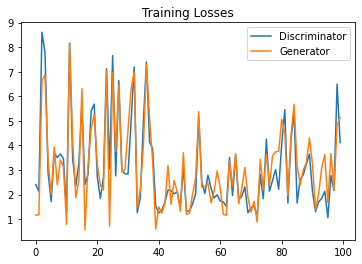

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

It's definitely much better than the results from the simple GAN MNIST model in [gan_mnist.ipynb](gan_mnist.ipynb).

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 8.1678 Generator Loss: 0.3599
Epoch:  2/100 Discriminator Loss: 1.6975 Generator Loss: 1.8691
Epoch:  3/100 Discriminator Loss: 1.2940 Generator Loss: 0.7339
Epoch:  4/100 Discriminator Loss: 9.7472 Generator Loss: 8.4693
Epoch:  5/100 Discriminator Loss: 2.3538 Generator Loss: 2.0690
Epoch:  6/100 Discriminator Loss: 2.4626 Generator Loss: 0.4662
Epoch:  7/100 Discriminator Loss: 1.5587 Generator Loss: 0.6999
Epoch:  8/100 Discriminator Loss: 7.6235 Generator Loss: 8.9563
Epoch:  9/100 Discriminator Loss: 2.1335 Generator Loss: 3.5613
Epoch: 10/100 Discriminator Loss: 5.2886 Generator Loss: 6.6770


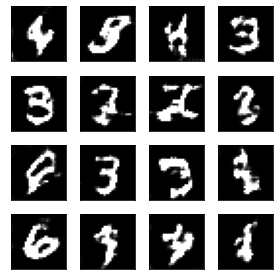

Epoch: 11/100 Discriminator Loss:10.7239 Generator Loss:11.4316
Epoch: 12/100 Discriminator Loss: 4.4924 Generator Loss: 6.8438
Epoch: 13/100 Discriminator Loss: 1.9638 Generator Loss: 3.4336
Epoch: 14/100 Discriminator Loss: 1.0122 Generator Loss: 1.9193
Epoch: 15/100 Discriminator Loss: 3.7509 Generator Loss: 1.9624
Epoch: 16/100 Discriminator Loss: 2.5328 Generator Loss: 1.0350
Epoch: 17/100 Discriminator Loss: 1.2547 Generator Loss: 1.7555
Epoch: 18/100 Discriminator Loss: 0.9484 Generator Loss: 1.6738
Epoch: 19/100 Discriminator Loss: 1.2571 Generator Loss: 1.3174
Epoch: 20/100 Discriminator Loss: 3.6104 Generator Loss: 4.2047


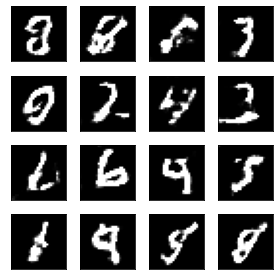

Epoch: 21/100 Discriminator Loss:16.2766 Generator Loss:14.9032
Epoch: 22/100 Discriminator Loss: 4.7835 Generator Loss: 3.1731
Epoch: 23/100 Discriminator Loss: 2.5082 Generator Loss: 1.9723
Epoch: 24/100 Discriminator Loss: 2.2204 Generator Loss: 2.4852
Epoch: 25/100 Discriminator Loss: 2.1636 Generator Loss: 1.3122
Epoch: 26/100 Discriminator Loss: 2.6544 Generator Loss: 4.6473
Epoch: 27/100 Discriminator Loss: 1.6384 Generator Loss: 1.3651
Epoch: 28/100 Discriminator Loss: 2.9572 Generator Loss: 1.9906
Epoch: 29/100 Discriminator Loss: 0.7846 Generator Loss: 2.6558
Epoch: 30/100 Discriminator Loss: 1.2340 Generator Loss: 1.7654


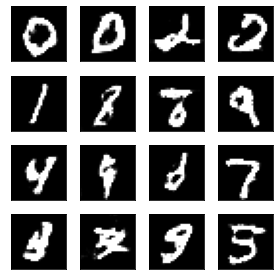

Epoch: 31/100 Discriminator Loss: 4.2637 Generator Loss: 3.4826
Epoch: 32/100 Discriminator Loss: 3.3436 Generator Loss: 2.4049
Epoch: 33/100 Discriminator Loss: 2.4298 Generator Loss: 0.9385
Epoch: 34/100 Discriminator Loss: 0.8486 Generator Loss: 2.0272
Epoch: 35/100 Discriminator Loss: 1.3213 Generator Loss: 1.1200
Epoch: 36/100 Discriminator Loss: 2.7782 Generator Loss: 3.9626
Epoch: 37/100 Discriminator Loss: 3.9075 Generator Loss: 4.6904
Epoch: 38/100 Discriminator Loss: 1.5362 Generator Loss: 0.8017
Epoch: 39/100 Discriminator Loss: 4.6787 Generator Loss: 5.1704
Epoch: 40/100 Discriminator Loss: 1.7770 Generator Loss: 2.8892


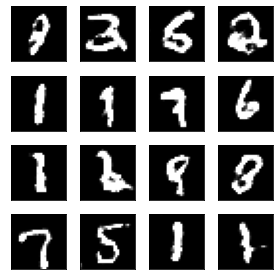

Epoch: 41/100 Discriminator Loss: 3.1378 Generator Loss: 2.9502
Epoch: 42/100 Discriminator Loss: 2.5776 Generator Loss: 3.0471
Epoch: 43/100 Discriminator Loss: 1.9805 Generator Loss: 1.1918
Epoch: 44/100 Discriminator Loss: 4.0694 Generator Loss: 5.5396
Epoch: 45/100 Discriminator Loss: 6.7120 Generator Loss: 7.7207
Epoch: 46/100 Discriminator Loss: 2.1494 Generator Loss: 2.8085
Epoch: 47/100 Discriminator Loss: 1.7700 Generator Loss: 3.2914
Epoch: 48/100 Discriminator Loss: 3.0532 Generator Loss: 4.0761
Epoch: 49/100 Discriminator Loss: 2.8451 Generator Loss: 3.1869
Epoch: 50/100 Discriminator Loss: 3.5170 Generator Loss: 5.4160


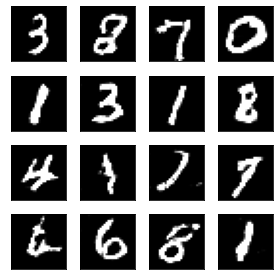

Epoch: 51/100 Discriminator Loss: 1.3650 Generator Loss: 3.1955
Epoch: 52/100 Discriminator Loss: 1.5339 Generator Loss: 1.0395
Epoch: 53/100 Discriminator Loss: 6.4243 Generator Loss: 7.7616
Epoch: 54/100 Discriminator Loss: 3.3442 Generator Loss: 3.8310
Epoch: 55/100 Discriminator Loss: 3.0820 Generator Loss: 4.1267
Epoch: 56/100 Discriminator Loss: 4.7001 Generator Loss: 0.1849
Epoch: 57/100 Discriminator Loss: 5.4096 Generator Loss: 6.9002
Epoch: 58/100 Discriminator Loss: 3.3875 Generator Loss: 2.2171
Epoch: 59/100 Discriminator Loss: 5.7617 Generator Loss: 6.7578
Epoch: 60/100 Discriminator Loss: 3.4727 Generator Loss: 4.1531


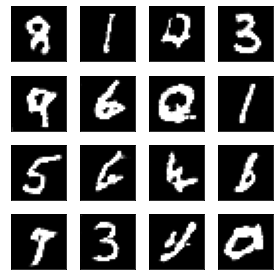

Epoch: 61/100 Discriminator Loss: 3.5938 Generator Loss: 2.0382
Epoch: 62/100 Discriminator Loss: 1.8765 Generator Loss: 3.1173
Epoch: 63/100 Discriminator Loss: 2.2481 Generator Loss: 1.3417
Epoch: 64/100 Discriminator Loss: 3.7534 Generator Loss: 3.5307
Epoch: 65/100 Discriminator Loss: 8.9515 Generator Loss: 7.1228
Epoch: 66/100 Discriminator Loss: 6.6932 Generator Loss: 9.0839
Epoch: 67/100 Discriminator Loss: 4.3483 Generator Loss: 5.2339
Epoch: 68/100 Discriminator Loss: 4.8816 Generator Loss: 3.4943
Epoch: 69/100 Discriminator Loss: 2.6724 Generator Loss: 1.6218
Epoch: 70/100 Discriminator Loss: 6.3805 Generator Loss: 7.5138


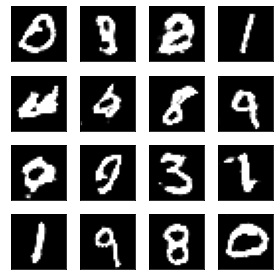

Epoch: 71/100 Discriminator Loss: 2.9419 Generator Loss: 4.3402
Epoch: 72/100 Discriminator Loss: 3.8097 Generator Loss: 4.9002
Epoch: 73/100 Discriminator Loss: 2.4517 Generator Loss: 0.7027
Epoch: 74/100 Discriminator Loss: 4.3707 Generator Loss: 4.1937
Epoch: 75/100 Discriminator Loss: 7.0261 Generator Loss: 7.3157
Epoch: 76/100 Discriminator Loss: 1.9092 Generator Loss: 3.2591
Epoch: 77/100 Discriminator Loss: 7.9735 Generator Loss: 7.5184
Epoch: 78/100 Discriminator Loss: 3.3842 Generator Loss: 1.7816
Epoch: 79/100 Discriminator Loss: 5.3614 Generator Loss: 0.2787
Epoch: 80/100 Discriminator Loss: 3.6704 Generator Loss: 0.9459


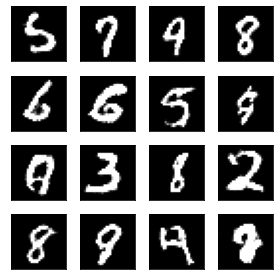

Epoch: 81/100 Discriminator Loss: 3.8421 Generator Loss: 0.8621
Epoch: 82/100 Discriminator Loss: 4.1707 Generator Loss: 2.6170
Epoch: 83/100 Discriminator Loss: 6.2783 Generator Loss: 6.8792
Epoch: 84/100 Discriminator Loss: 6.4625 Generator Loss: 6.8908
Epoch: 85/100 Discriminator Loss: 2.2608 Generator Loss: 1.0512
Epoch: 86/100 Discriminator Loss: 5.0638 Generator Loss: 6.2253
Epoch: 87/100 Discriminator Loss: 3.3160 Generator Loss: 1.5041
Epoch: 88/100 Discriminator Loss: 5.8454 Generator Loss: 5.6157
Epoch: 89/100 Discriminator Loss: 8.3393 Generator Loss: 6.4501
Epoch: 90/100 Discriminator Loss: 3.7031 Generator Loss: 3.2237


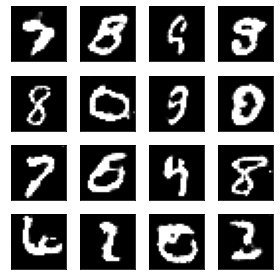

Epoch: 91/100 Discriminator Loss: 5.5819 Generator Loss: 5.1983
Epoch: 92/100 Discriminator Loss: 3.8553 Generator Loss: 6.1045
Epoch: 93/100 Discriminator Loss: 1.8208 Generator Loss: 2.1854
Epoch: 94/100 Discriminator Loss: 3.1164 Generator Loss: 0.7816
Epoch: 95/100 Discriminator Loss: 6.9054 Generator Loss: 7.2204
Epoch: 96/100 Discriminator Loss: 3.2152 Generator Loss: 4.1020
Epoch: 97/100 Discriminator Loss:11.6264 Generator Loss:10.8661
Epoch: 98/100 Discriminator Loss:12.1381 Generator Loss:12.9125
Epoch: 99/100 Discriminator Loss: 3.7703 Generator Loss: 2.3952
Epoch:100/100 Discriminator Loss: 8.0180 Generator Loss: 8.3485


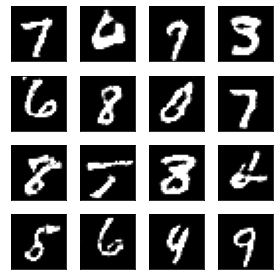

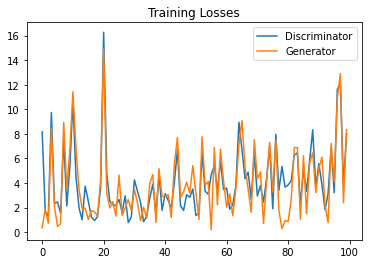

In [16]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);

I used leaky_relu=0.2 for the above experiment.  The losses oscillates more.  The generated images look as good.

## References

<a id="ref1"></a>
### [1] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf